## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'fourier'
CHANNEL = 'green'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
green_fourier_full_agriVision.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'c:\\Users\\riyap\\OneDrive\\Documents\\GitHub\\hierarchical-bayesian-model-validation\\results\\case-studies\\agriVision\\full\\fourier\\green'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 45000,
 3: 72000,
 4: 63000,
 5: 117000,
 6: 126000,
 7: 171000,
 8: 189000,
 9: 297000,
 10: 396000,
 11: 495000,
 12: 648000,
 13: 882000,
 14: 1134000,
 15: 1539000,
 16: 1953000,
 17: 2574000,
 18: 3456000,
 19: 4563000,
 20: 5967000,
 21: 8010000,
 22: 10395000,
 23: 13887000,
 24: 18297000,
 25: 24057000,
 26: 31968000,
 27: 42183000,
 28: 55764000,
 29: 73701000,
 30: 97326000,
 31: 108342000,
 32: 59634000,
 33: 21420000}

Running 12760 CDFs


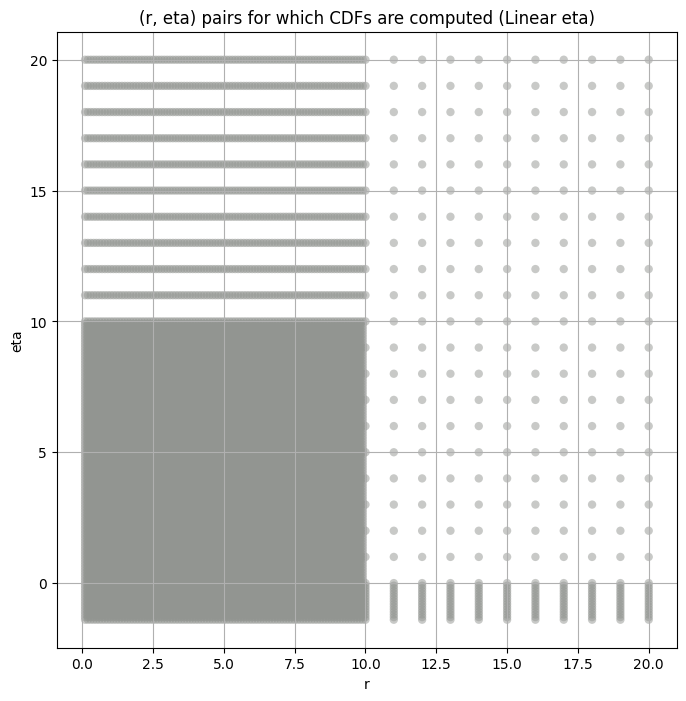

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


100%|██████████| 100000/100000 [00:59<00:00, 1674.50it/s]


Band 5


100%|██████████| 100000/100000 [00:58<00:00, 1710.50it/s]


Band 8


100%|██████████| 100000/100000 [01:05<00:00, 1534.61it/s]


Band 11


100%|██████████| 100000/100000 [01:03<00:00, 1584.97it/s]


Band 14


100%|██████████| 100000/100000 [01:00<00:00, 1662.36it/s]


Band 17


100%|██████████| 100000/100000 [01:04<00:00, 1557.99it/s]


Band 20


100%|██████████| 100000/100000 [01:04<00:00, 1553.35it/s]


Band 23


100%|██████████| 100000/100000 [01:00<00:00, 1647.88it/s]


Band 26


100%|██████████| 100000/100000 [01:04<00:00, 1542.48it/s]


Band 29


100%|██████████| 100000/100000 [01:01<00:00, 1636.71it/s]


Band 32


100%|██████████| 100000/100000 [01:00<00:00, 1654.02it/s]


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,1142.248300,671.469300,1944.989000,473.18463,99.004295,1019.8701,45000.0
5,758.162230,365.148160,2692.950400,2945.43360,101.462210,5367.8350,117000.0
8,241.405010,134.156190,529.040800,918.95044,93.302230,2766.5867,189000.0
11,139.544980,56.528194,599.460300,6517.12160,80.002920,6412.9240,495000.0
14,45.202160,23.660954,126.899790,1856.47970,73.761430,4089.5234,1134000.0
17,29.421543,11.309689,173.463560,9698.96400,65.262900,7472.8240,2574000.0
20,16.877602,6.535955,89.357990,8663.62000,69.641340,7133.9710,5967000.0
23,7.124417,2.409751,47.371037,16824.38000,62.361816,8305.8750,13887000.0
26,3.963180,0.637729,39.924670,32372.20000,72.455315,9320.1260,31968000.0


## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
band,,,,,,,,,,,,
2,1142.248300,1142.248291,579.944031,462.250031,397.802582,361.053070,317.847748,289.432251,268.237793,251.354218,237.443787,207.168640
5,758.162230,758.162231,387.732361,322.603088,285.245361,259.443634,226.535767,204.611130,188.476135,175.948456,166.159760,144.824814
8,241.405010,241.405014,142.407257,119.977760,106.394661,97.053368,84.606209,76.894821,71.213913,66.865570,63.406651,55.922592
11,139.544980,139.544983,59.893166,51.025661,45.757832,42.169315,37.413727,34.343628,32.173237,30.484629,29.123484,26.141581
14,45.202160,45.202160,24.949785,21.366411,19.304523,17.914574,16.050779,14.858236,14.014368,13.367860,12.847286,11.700813
17,29.421543,29.421543,11.883146,10.281528,9.353213,8.729887,7.923803,7.406673,7.030638,6.737899,6.498001,5.958976
20,16.877602,16.877602,6.895647,5.936321,5.379202,5.003891,4.515661,4.201748,3.974608,3.797638,3.652373,3.324707
23,7.124417,7.124417,2.525505,2.194684,2.002818,1.873383,1.705102,1.595347,1.513911,1.448497,1.393457,1.265475
26,3.963180,3.963181,0.670722,0.576224,0.521674,0.484847,0.436758,0.405285,0.381889,0.363163,0.347433,0.311123


####
Band  2


100%|██████████| 12760/12760 [00:44<00:00, 286.25it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.031568759981131136 1142.2483


100%|██████████| 12760/12760 [00:48<00:00, 263.74it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.018674533582900207 579.94403


100%|██████████| 12760/12760 [00:48<00:00, 265.70it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.01417227031131485 462.25003


100%|██████████| 12760/12760 [00:46<00:00, 272.90it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.011373662689762032 397.80258


100%|██████████| 12760/12760 [00:45<00:00, 278.29it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.010068704140938967 361.05307


100%|██████████| 12760/12760 [00:43<00:00, 291.63it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.00820950554500427 317.84775


100%|██████████| 12760/12760 [00:47<00:00, 270.73it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.008920171107352437 289.43225


100%|██████████| 12760/12760 [00:45<00:00, 277.47it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.010370632562328508 268.2378


100%|██████████| 12760/12760 [00:46<00:00, 276.63it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.011544439851337684 251.35422


100%|██████████| 12760/12760 [00:45<00:00, 278.55it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.01289330147066925 237.44379


100%|██████████| 12760/12760 [00:43<00:00, 295.54it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.016795641733554634 207.16864
Number of samples: 45000, Without approximation : 45000.0


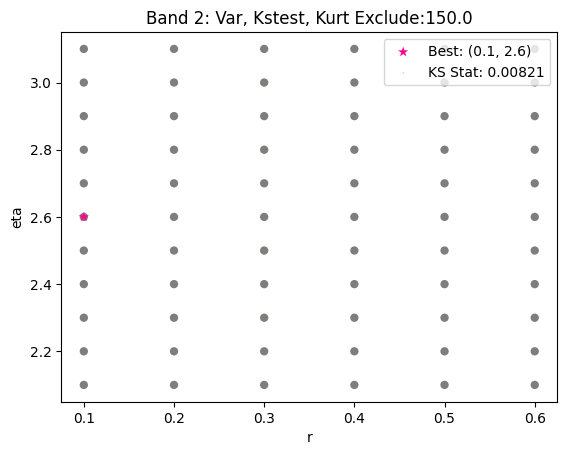

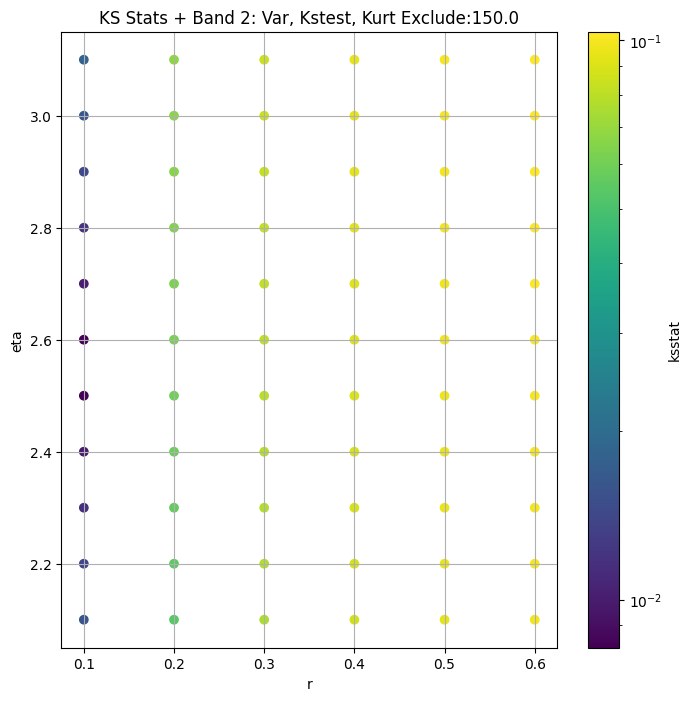

####
Band  5


100%|██████████| 12760/12760 [01:49<00:00, 116.18it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.03279515257443759 758.16223


100%|██████████| 12760/12760 [01:50<00:00, 115.69it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.022442421534620574 387.73236


100%|██████████| 12760/12760 [01:52<00:00, 113.47it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.018179384430248677 322.6031


100%|██████████| 12760/12760 [01:50<00:00, 115.19it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.016534746780009518 285.24536


100%|██████████| 12760/12760 [01:54<00:00, 111.31it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.013963991412332288 259.44363


100%|██████████| 12760/12760 [01:50<00:00, 115.75it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.011877940290780223 226.53577


100%|██████████| 12760/12760 [01:53<00:00, 112.07it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.009440828585150107 204.61113


100%|██████████| 12760/12760 [01:53<00:00, 112.02it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.007975171475924053 188.47614


100%|██████████| 12760/12760 [01:49<00:00, 116.00it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.006954458548620951 175.94846


100%|██████████| 12760/12760 [01:49<00:00, 116.28it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.005591414114080151 166.15976


100%|██████████| 12760/12760 [01:42<00:00, 124.12it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.007524244443488315 144.82481
Number of samples: 100000, Without approximation : 117000.0


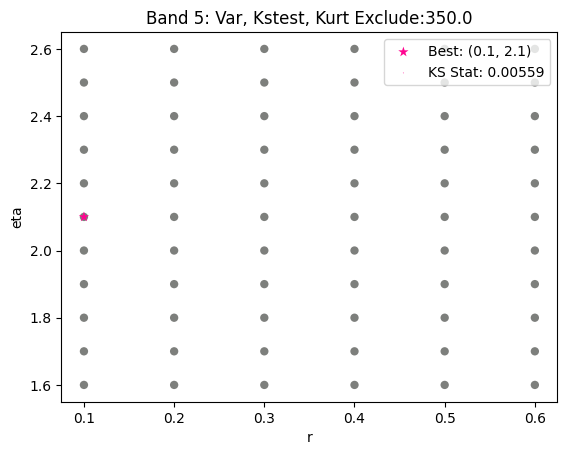

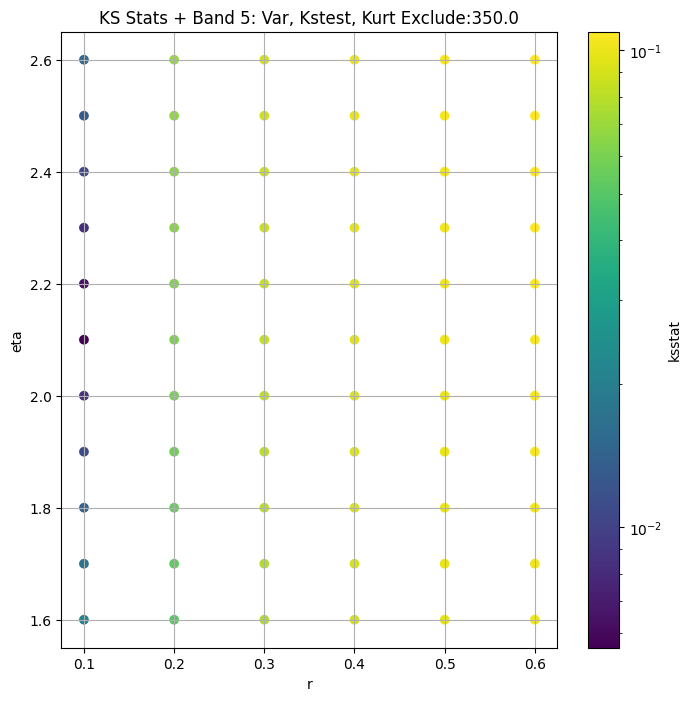

####
Band  8


100%|██████████| 12760/12760 [01:45<00:00, 120.66it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.03341238068801961 241.40501


100%|██████████| 12760/12760 [01:49<00:00, 116.35it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.022279161392841806 142.40726


100%|██████████| 12760/12760 [01:43<00:00, 123.32it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.018071401005154003 119.97776


100%|██████████| 12760/12760 [01:41<00:00, 125.29it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.015379548734317905 106.39466


100%|██████████| 12760/12760 [01:41<00:00, 126.12it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.013124082361505529 97.05337


100%|██████████| 12760/12760 [01:43<00:00, 123.37it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.010925090980850274 84.60621


100%|██████████| 12760/12760 [01:42<00:00, 124.59it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.00827638969588873 76.89482


100%|██████████| 12760/12760 [01:44<00:00, 122.18it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.006609426124322915 71.21391


100%|██████████| 12760/12760 [01:42<00:00, 124.08it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.005144019066709138 66.86557


100%|██████████| 12760/12760 [01:45<00:00, 120.74it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.00570539495133815 63.40665


100%|██████████| 12760/12760 [01:41<00:00, 125.98it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.007388036883940519 55.922592
Number of samples: 100000, Without approximation : 189000.0


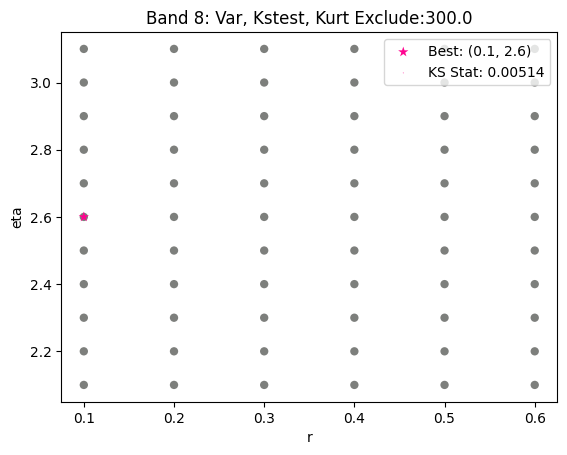

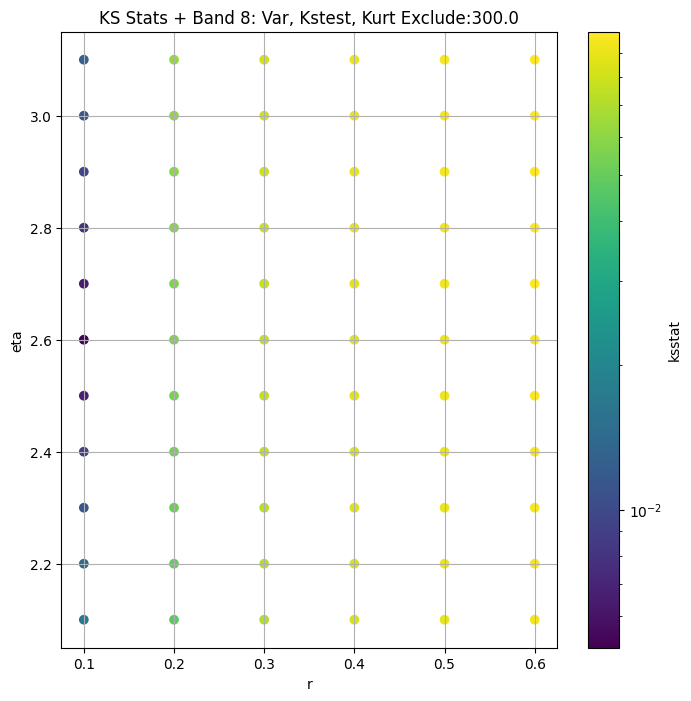

####
Band  11


100%|██████████| 12760/12760 [01:40<00:00, 127.44it/s]


Finding Minimum after computing 12760 CDFs
11 0 0.035067339017012866 139.54498


100%|██████████| 12760/12760 [01:43<00:00, 123.74it/s]


Finding Minimum after computing 12760 CDFs
11 25 0.01782934904800526 59.893166


100%|██████████| 12760/12760 [01:44<00:00, 122.09it/s]


Finding Minimum after computing 12760 CDFs
11 50 0.01378717773055893 51.02566


100%|██████████| 12760/12760 [01:44<00:00, 121.69it/s]


Finding Minimum after computing 12760 CDFs
11 75 0.011494910162860528 45.75783


100%|██████████| 12760/12760 [01:40<00:00, 126.40it/s]


Finding Minimum after computing 12760 CDFs
11 100 0.009285645483412375 42.169315


100%|██████████| 12760/12760 [01:41<00:00, 125.39it/s]


Finding Minimum after computing 12760 CDFs
11 150 0.0063214224396793695 37.413727


100%|██████████| 12760/12760 [01:42<00:00, 124.86it/s]


Finding Minimum after computing 12760 CDFs
11 200 0.003739003164514032 34.343628


100%|██████████| 12760/12760 [01:41<00:00, 126.22it/s]


Finding Minimum after computing 12760 CDFs
11 250 0.0038790264252416273 32.173237


100%|██████████| 12760/12760 [01:42<00:00, 124.34it/s]


Finding Minimum after computing 12760 CDFs
11 300 0.004543301608928907 30.484629


100%|██████████| 12760/12760 [01:40<00:00, 126.61it/s]


Finding Minimum after computing 12760 CDFs
11 350 0.005108712679781857 29.123484


100%|██████████| 12760/12760 [01:46<00:00, 119.74it/s]


Finding Minimum after computing 12760 CDFs
11 500 0.006793109973808664 26.14158
Number of samples: 100000, Without approximation : 495000.0


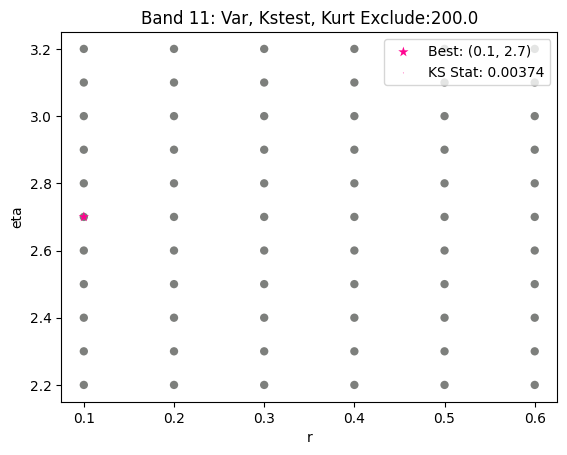

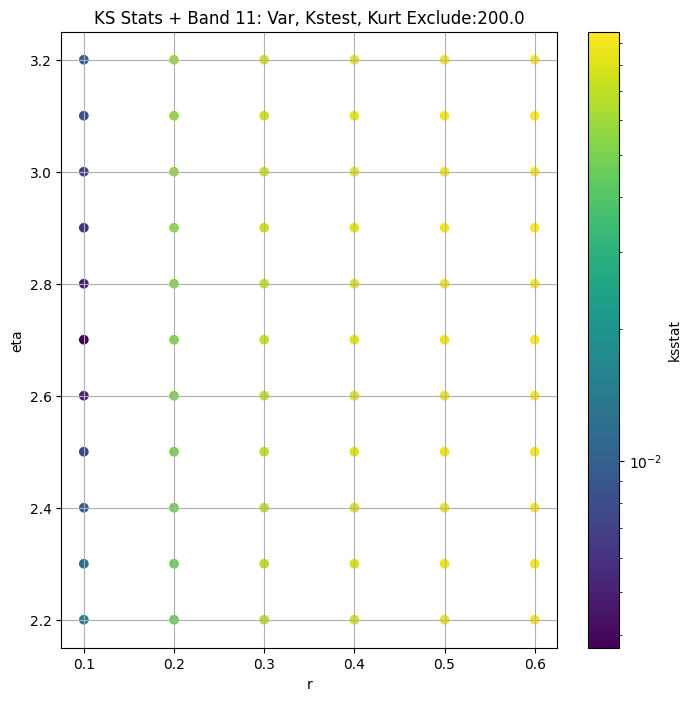

####
Band  14


100%|██████████| 12760/12760 [01:44<00:00, 122.48it/s]


Finding Minimum after computing 12760 CDFs
14 0 0.026370257217739168 45.20216


100%|██████████| 12760/12760 [01:44<00:00, 121.55it/s]


Finding Minimum after computing 12760 CDFs
14 25 0.014280295360573847 24.949785


100%|██████████| 12760/12760 [01:44<00:00, 122.47it/s]


Finding Minimum after computing 12760 CDFs
14 50 0.009793881908427726 21.366411


100%|██████████| 12760/12760 [01:43<00:00, 122.80it/s]


Finding Minimum after computing 12760 CDFs
14 75 0.007347840723420929 19.304523


100%|██████████| 12760/12760 [01:45<00:00, 120.90it/s]


Finding Minimum after computing 12760 CDFs
14 100 0.005474585772589635 17.914574


100%|██████████| 12760/12760 [01:45<00:00, 121.23it/s]


Finding Minimum after computing 12760 CDFs
14 150 0.0027052406544457175 16.05078


100%|██████████| 12760/12760 [01:43<00:00, 122.92it/s]


Finding Minimum after computing 12760 CDFs
14 200 0.0026551511115235904 14.858236


100%|██████████| 12760/12760 [01:42<00:00, 124.88it/s]


Finding Minimum after computing 12760 CDFs
14 250 0.003274572132332877 14.014368


100%|██████████| 12760/12760 [01:44<00:00, 122.35it/s]


Finding Minimum after computing 12760 CDFs
14 300 0.003910191912827771 13.36786


100%|██████████| 12760/12760 [01:40<00:00, 127.15it/s]


Finding Minimum after computing 12760 CDFs
14 350 0.004677186425994807 12.847286


100%|██████████| 12760/12760 [01:41<00:00, 125.15it/s]


Finding Minimum after computing 12760 CDFs
14 500 0.0065059308735047824 11.700813
Number of samples: 100000, Without approximation : 1134000.0


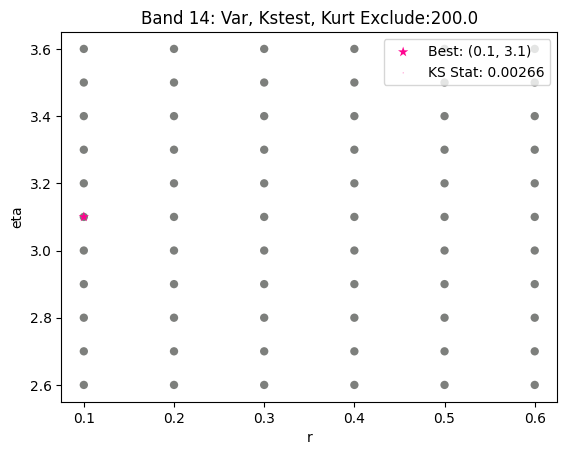

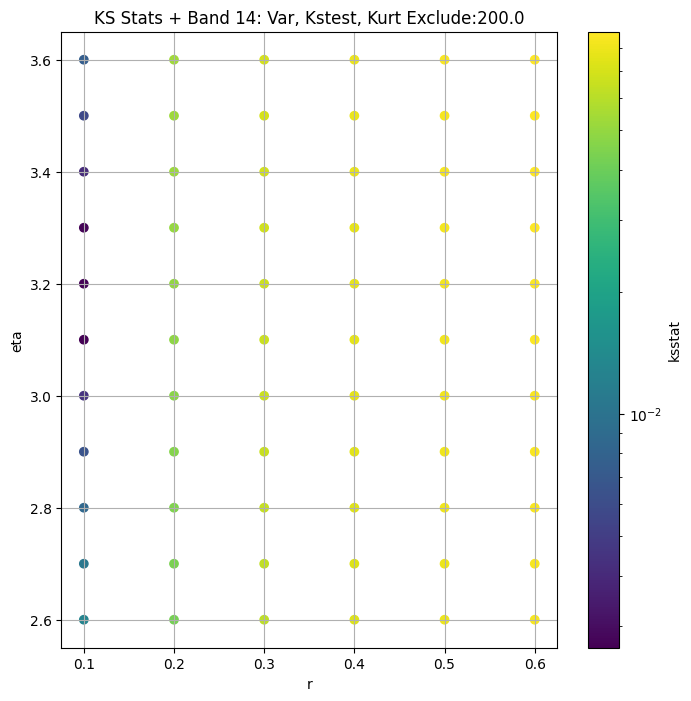

####
Band  17


100%|██████████| 12760/12760 [01:44<00:00, 122.37it/s]


Finding Minimum after computing 12760 CDFs
17 0 0.030544735932077738 29.421543


100%|██████████| 12760/12760 [01:41<00:00, 125.37it/s]


Finding Minimum after computing 12760 CDFs
17 25 0.011021773313138236 11.883146


100%|██████████| 12760/12760 [01:42<00:00, 124.42it/s]


Finding Minimum after computing 12760 CDFs
17 50 0.007657855842800904 10.281528


100%|██████████| 12760/12760 [01:39<00:00, 128.60it/s]


Finding Minimum after computing 12760 CDFs
17 75 0.0052122647737550265 9.353213


100%|██████████| 12760/12760 [01:42<00:00, 124.39it/s]


Finding Minimum after computing 12760 CDFs
17 100 0.004066027955962809 8.729887


100%|██████████| 12760/12760 [01:41<00:00, 125.20it/s]


Finding Minimum after computing 12760 CDFs
17 150 0.0020408949448707694 7.923803


100%|██████████| 12760/12760 [01:44<00:00, 122.28it/s]


Finding Minimum after computing 12760 CDFs
17 200 0.0027369353986989404 7.4066734


100%|██████████| 12760/12760 [01:39<00:00, 127.78it/s]


Finding Minimum after computing 12760 CDFs
17 250 0.003540341481527154 7.030638


100%|██████████| 12760/12760 [01:44<00:00, 122.00it/s]


Finding Minimum after computing 12760 CDFs
17 300 0.0042548341020196105 6.7378993


100%|██████████| 12760/12760 [01:47<00:00, 118.89it/s]


Finding Minimum after computing 12760 CDFs
17 350 0.005046907922721899 6.498001


100%|██████████| 12760/12760 [01:44<00:00, 121.56it/s]


Finding Minimum after computing 12760 CDFs
17 500 0.007100014563351168 5.958976
Number of samples: 100000, Without approximation : 2574000.0


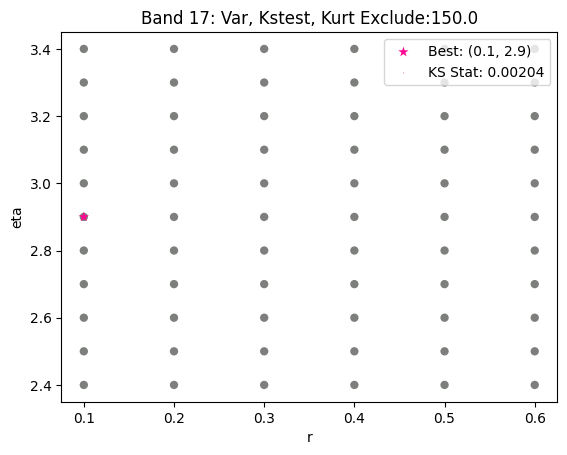

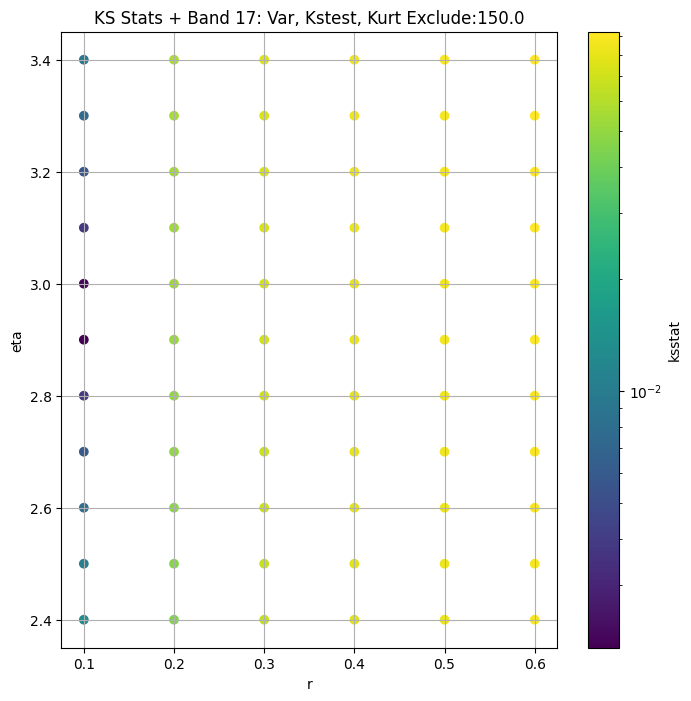

####
Band  20


100%|██████████| 12760/12760 [01:46<00:00, 119.62it/s]


Finding Minimum after computing 12760 CDFs
20 0 0.030723948564689407 16.877602


100%|██████████| 12760/12760 [01:46<00:00, 119.55it/s]


Finding Minimum after computing 12760 CDFs
20 25 0.012849105335886346 6.895647


100%|██████████| 12760/12760 [01:49<00:00, 116.24it/s]


Finding Minimum after computing 12760 CDFs
20 50 0.009612365890553531 5.936321


100%|██████████| 12760/12760 [01:51<00:00, 114.41it/s]


Finding Minimum after computing 12760 CDFs
20 75 0.008254650325353219 5.3792024


100%|██████████| 12760/12760 [01:47<00:00, 118.27it/s]


Finding Minimum after computing 12760 CDFs
20 100 0.006781075253067481 5.003891


100%|██████████| 12760/12760 [01:51<00:00, 114.21it/s]


Finding Minimum after computing 12760 CDFs
20 150 0.004538027171917536 4.515661


100%|██████████| 12760/12760 [01:47<00:00, 118.15it/s]


Finding Minimum after computing 12760 CDFs
20 200 0.0033613042945208026 4.201748


100%|██████████| 12760/12760 [01:50<00:00, 115.20it/s]


Finding Minimum after computing 12760 CDFs
20 250 0.004599972281392254 3.974608


100%|██████████| 12760/12760 [01:47<00:00, 119.25it/s]


Finding Minimum after computing 12760 CDFs
20 300 0.005063269151696664 3.7976377


100%|██████████| 12760/12760 [01:50<00:00, 115.97it/s]


Finding Minimum after computing 12760 CDFs
20 350 0.005621750125363364 3.6523726


100%|██████████| 12760/12760 [01:50<00:00, 115.69it/s]


Finding Minimum after computing 12760 CDFs
20 500 0.007575040168362648 3.3247073
Number of samples: 100000, Without approximation : 5967000.0


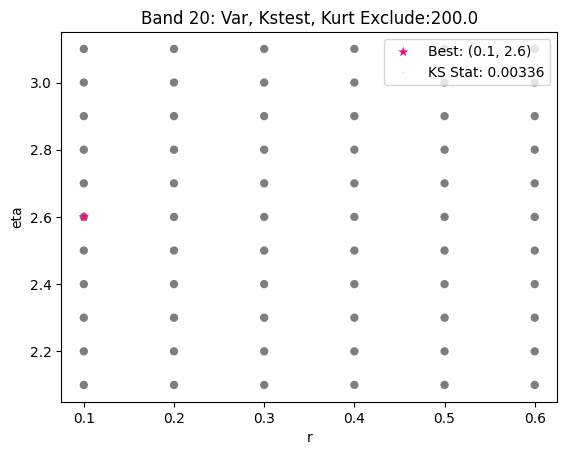

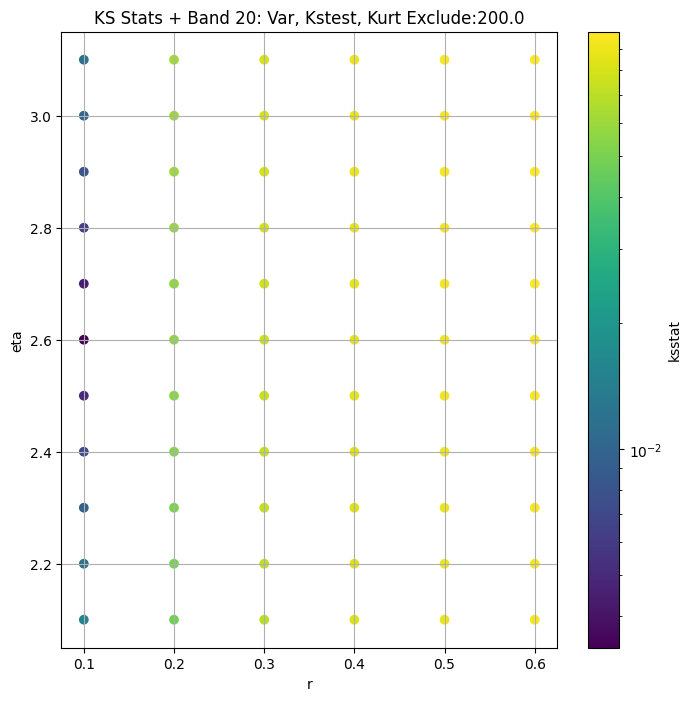

####
Band  23


100%|██████████| 12760/12760 [01:54<00:00, 111.81it/s]


Finding Minimum after computing 12760 CDFs
23 0 0.03394726173186946 7.1244173


100%|██████████| 12760/12760 [01:49<00:00, 116.37it/s]


Finding Minimum after computing 12760 CDFs
23 25 0.01392599415904916 2.5255046


100%|██████████| 12760/12760 [01:51<00:00, 114.43it/s]


Finding Minimum after computing 12760 CDFs
23 50 0.009841734096203258 2.194684


100%|██████████| 12760/12760 [01:52<00:00, 113.13it/s]


Finding Minimum after computing 12760 CDFs
23 75 0.008071723989760304 2.002818


100%|██████████| 12760/12760 [01:54<00:00, 111.20it/s]


Finding Minimum after computing 12760 CDFs
23 100 0.00783720382876607 1.8733832


100%|██████████| 12760/12760 [01:55<00:00, 110.81it/s]


Finding Minimum after computing 12760 CDFs
23 150 0.005195381291504542 1.7051018


100%|██████████| 12760/12760 [01:53<00:00, 112.90it/s]


Finding Minimum after computing 12760 CDFs
23 200 0.004359138986482658 1.5953473


100%|██████████| 12760/12760 [01:56<00:00, 109.81it/s]


Finding Minimum after computing 12760 CDFs
23 250 0.005437964842029429 1.5139108


100%|██████████| 12760/12760 [01:54<00:00, 111.21it/s]


Finding Minimum after computing 12760 CDFs
23 300 0.0057416013466247105 1.4484969


100%|██████████| 12760/12760 [01:52<00:00, 113.89it/s]


Finding Minimum after computing 12760 CDFs
23 350 0.006613546307177146 1.3934567


100%|██████████| 12760/12760 [01:46<00:00, 119.55it/s]


Finding Minimum after computing 12760 CDFs
23 500 0.008266155006578235 1.2654746
Number of samples: 100000, Without approximation : 13887000.0


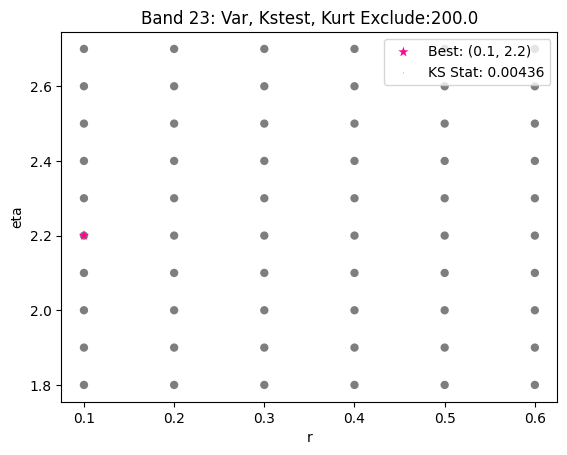

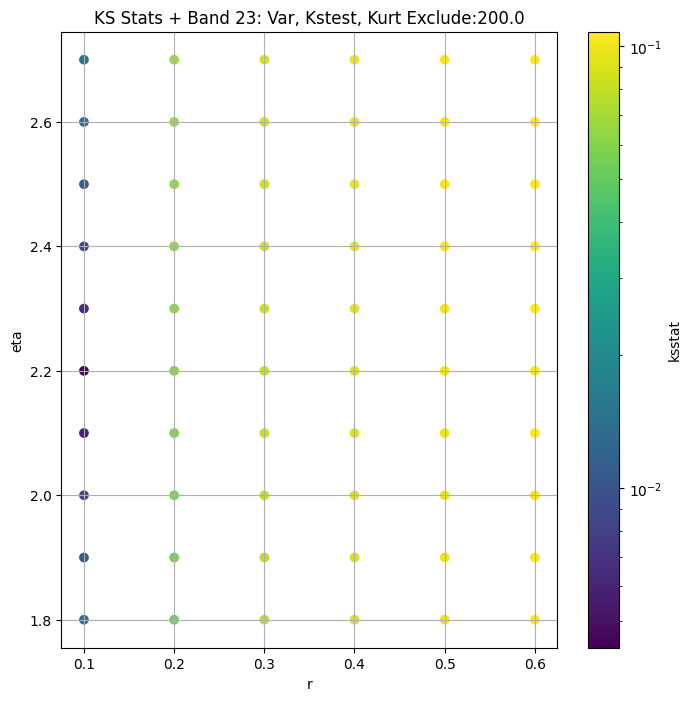

####
Band  26


100%|██████████| 12760/12760 [01:50<00:00, 115.11it/s]


Finding Minimum after computing 12760 CDFs
26 0 0.04689472028065084 3.9631805


100%|██████████| 12760/12760 [01:46<00:00, 119.96it/s]


Finding Minimum after computing 12760 CDFs
26 25 0.01522053272824353 0.67072225


100%|██████████| 12760/12760 [01:49<00:00, 116.48it/s]


Finding Minimum after computing 12760 CDFs
26 50 0.012745376277222609 0.57622355


100%|██████████| 12760/12760 [01:47<00:00, 118.68it/s]


Finding Minimum after computing 12760 CDFs
26 75 0.009707309619764404 0.52167356


100%|██████████| 12760/12760 [01:51<00:00, 114.83it/s]


Finding Minimum after computing 12760 CDFs
26 100 0.009009492117142193 0.48484653


100%|██████████| 12760/12760 [01:48<00:00, 117.23it/s]


Finding Minimum after computing 12760 CDFs
26 150 0.006839583070480382 0.43675792


100%|██████████| 12760/12760 [01:49<00:00, 116.77it/s]


Finding Minimum after computing 12760 CDFs
26 200 0.0065866088494195285 0.40528482


100%|██████████| 12760/12760 [01:49<00:00, 116.02it/s]


Finding Minimum after computing 12760 CDFs
26 250 0.006114605668789186 0.38188905


100%|██████████| 12760/12760 [01:48<00:00, 117.45it/s]


Finding Minimum after computing 12760 CDFs
26 300 0.007111837391687192 0.36316264


100%|██████████| 12760/12760 [01:49<00:00, 116.54it/s]


Finding Minimum after computing 12760 CDFs
26 350 0.007878125378906642 0.34743282


100%|██████████| 12760/12760 [01:48<00:00, 117.70it/s]


Finding Minimum after computing 12760 CDFs
26 500 0.008790468682539188 0.31112263
Number of samples: 100000, Without approximation : 31968000.0


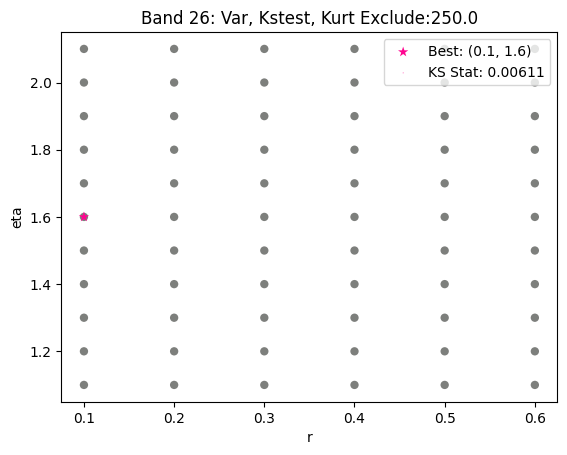

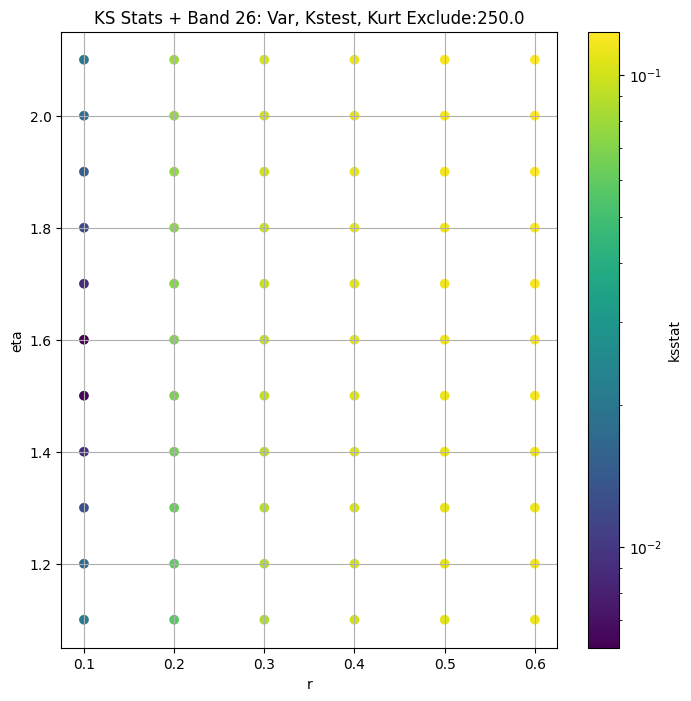

####
Band  29


100%|██████████| 12760/12760 [01:47<00:00, 118.70it/s]


Finding Minimum after computing 12760 CDFs
29 0 0.04554328331212658 0.6209732


100%|██████████| 12760/12760 [01:43<00:00, 123.45it/s]


Finding Minimum after computing 12760 CDFs
29 25 0.017952088287280676 0.08441072


100%|██████████| 12760/12760 [01:43<00:00, 122.74it/s]


Finding Minimum after computing 12760 CDFs
29 50 0.017490485124201843 0.07098277


100%|██████████| 12760/12760 [01:46<00:00, 119.83it/s]


Finding Minimum after computing 12760 CDFs
29 75 0.01534731952084925 0.06355044


100%|██████████| 12760/12760 [01:52<00:00, 113.83it/s]


Finding Minimum after computing 12760 CDFs
29 100 0.014926251325935141 0.05870762


100%|██████████| 12760/12760 [02:27<00:00, 86.23it/s]


Finding Minimum after computing 12760 CDFs
29 150 0.012021427674854285 0.052562587


100%|██████████| 12760/12760 [02:02<00:00, 104.10it/s]


Finding Minimum after computing 12760 CDFs
29 200 0.010942657208353662 0.048567455


100%|██████████| 12760/12760 [01:47<00:00, 119.02it/s]


Finding Minimum after computing 12760 CDFs
29 250 0.01070418501592485 0.04558793


100%|██████████| 12760/12760 [01:55<00:00, 110.42it/s]


Finding Minimum after computing 12760 CDFs
29 300 0.009827701609285477 0.043192375


100%|██████████| 12760/12760 [01:49<00:00, 116.19it/s]


Finding Minimum after computing 12760 CDFs
29 350 0.00994934552040927 0.041178912


100%|██████████| 12760/12760 [01:56<00:00, 109.43it/s]


Finding Minimum after computing 12760 CDFs
29 500 0.011293038716332804 0.036524203
Number of samples: 100000, Without approximation : 73701000.0


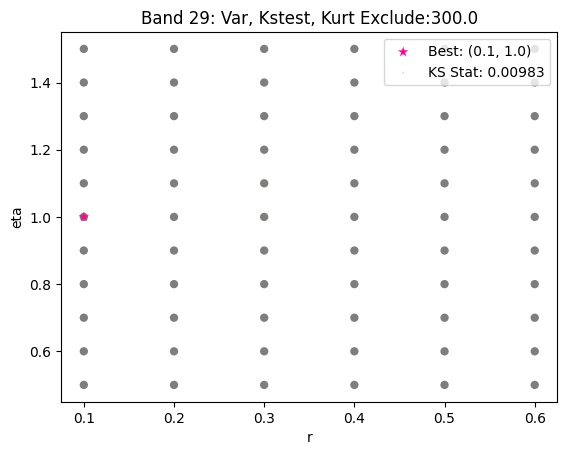

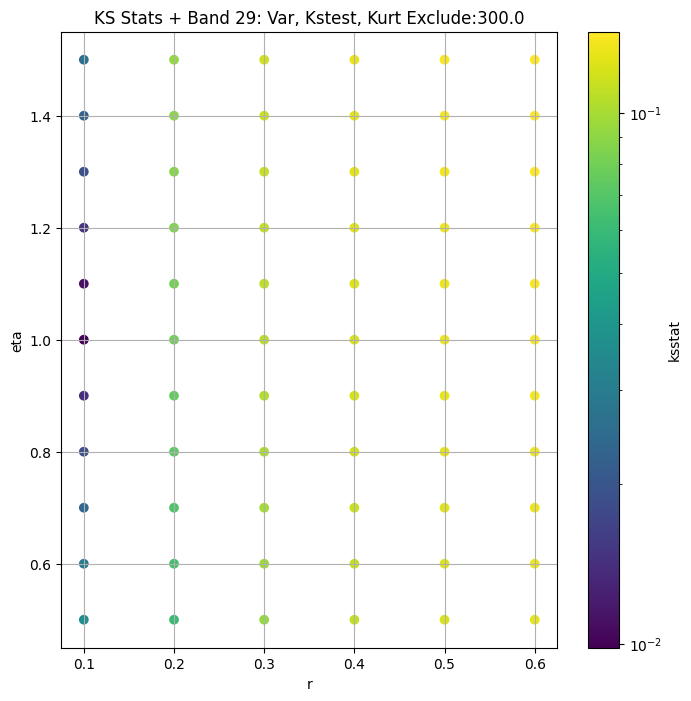

####
Band  32


100%|██████████| 12760/12760 [01:49<00:00, 116.51it/s]


Finding Minimum after computing 12760 CDFs
32 0 0.033737002635425395 0.015306049


100%|██████████| 12760/12760 [01:51<00:00, 114.50it/s]


Finding Minimum after computing 12760 CDFs
32 25 0.02547290431290694 0.008699079


100%|██████████| 12760/12760 [01:48<00:00, 118.04it/s]


Finding Minimum after computing 12760 CDFs
32 50 0.021948334744951503 0.007358214


100%|██████████| 12760/12760 [01:47<00:00, 118.33it/s]


Finding Minimum after computing 12760 CDFs
32 75 0.019919695760965583 0.0066147083


100%|██████████| 12760/12760 [01:44<00:00, 121.89it/s]


Finding Minimum after computing 12760 CDFs
32 100 0.01838051598436019 0.00613204


100%|██████████| 12760/12760 [01:48<00:00, 117.87it/s]


Finding Minimum after computing 12760 CDFs
32 150 0.01721865030861669 0.005518109


100%|██████████| 12760/12760 [01:48<00:00, 117.50it/s]


Finding Minimum after computing 12760 CDFs
32 200 0.01545178541401196 0.0051161516


100%|██████████| 12760/12760 [01:43<00:00, 123.52it/s]


Finding Minimum after computing 12760 CDFs
32 250 0.014033887825612962 0.004813994


100%|██████████| 12760/12760 [01:47<00:00, 119.20it/s]


Finding Minimum after computing 12760 CDFs
32 300 0.013069111372447262 0.0045694276


100%|██████████| 12760/12760 [01:44<00:00, 122.61it/s]


Finding Minimum after computing 12760 CDFs
32 350 0.01236851784065135 0.0043625077


100%|██████████| 12760/12760 [01:44<00:00, 121.75it/s]


Finding Minimum after computing 12760 CDFs
32 500 0.011066496844570756 0.0038790104
Number of samples: 100000, Without approximation : 59634000.0


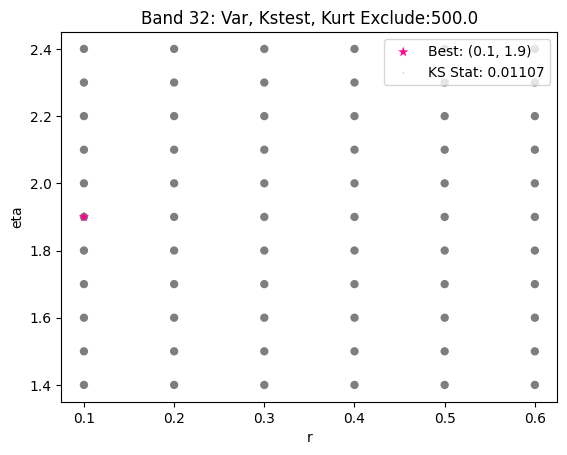

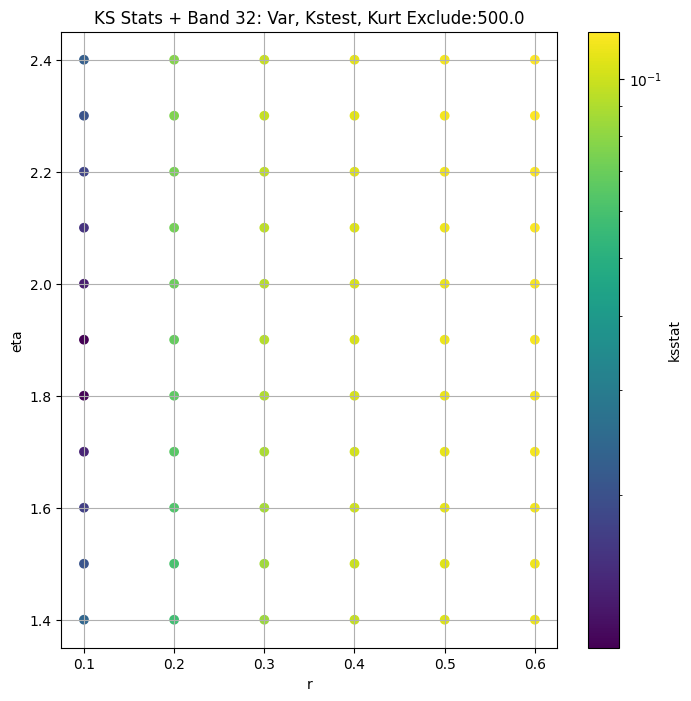

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
band,,,,,,,,,,,,,,
2,1142.248300,671.469300,1944.989000,473.18463,99.004295,1019.8701,45000.0,0.008210,0.1,2.6,8.526864e-15,150.0,317.847750,0.006398
5,758.162230,365.148160,2692.950400,2945.43360,101.462210,5367.8350,117000.0,0.005591,0.1,2.1,1.435313e-14,350.0,166.159760,0.003969
8,241.405010,134.156190,529.040800,918.95044,93.302230,2766.5867,189000.0,0.005144,0.1,2.6,1.793795e-15,300.0,66.865570,0.003123
11,139.544980,56.528194,599.460300,6517.12160,80.002920,6412.9240,495000.0,0.003739,0.1,2.7,7.406790e-16,200.0,34.343628,0.001930
14,45.202160,23.660954,126.899790,1856.47970,73.761430,4089.5234,1134000.0,0.002655,0.1,3.1,1.399905e-16,200.0,14.858236,0.001275
17,29.421543,11.309689,173.463560,9698.96400,65.262900,7472.8240,2574000.0,0.002041,0.1,2.9,1.119840e-16,150.0,7.923803,0.000846
20,16.877602,6.535955,89.357990,8663.62000,69.641340,7133.9710,5967000.0,0.003361,0.1,2.6,1.127198e-16,200.0,4.201748,0.000556
23,7.124417,2.409751,47.371037,16824.38000,62.361816,8305.8750,13887000.0,0.004359,0.1,2.2,1.078501e-16,200.0,1.595347,0.000364
26,3.963180,0.637729,39.924670,32372.20000,72.455315,9320.1260,31968000.0,0.006115,0.1,1.6,1.241516e-16,250.0,0.381889,0.000240


In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


100%|██████████| 522/522 [00:01<00:00, 290.89it/s]


Finding Minimum after computing 522 CDFs
band 2, 150.0 + 100 = 250, ksstat: 0.011297365731316233, var: 268.23779296875


100%|██████████| 522/522 [00:01<00:00, 293.22it/s]


Finding Minimum after computing 522 CDFs
band 2, 150.0 + 75 = 225, ksstat: 0.010491205163956185, var: 278.081787109375


100%|██████████| 522/522 [00:01<00:00, 299.08it/s]


Finding Minimum after computing 522 CDFs
band 2, 150.0 + 50 = 200, ksstat: 0.009462664703623225, var: 289.4322509765625


100%|██████████| 522/522 [00:01<00:00, 298.22it/s]


Finding Minimum after computing 522 CDFs
band 2, 150.0 + 25 = 175, ksstat: 0.008531994664828013, var: 302.4720764160156


100%|██████████| 522/522 [00:01<00:00, 300.90it/s]


Finding Minimum after computing 522 CDFs
band 2, 150.0 + 0 = 150, ksstat: 0.008117170077269364, var: 317.8477478027344


100%|██████████| 522/522 [00:01<00:00, 299.82it/s]


Finding Minimum after computing 522 CDFs
band 2, 150.0 + -25 = 125, ksstat: 0.008345194683300194, var: 336.590576171875


100%|██████████| 522/522 [00:01<00:00, 294.25it/s]


Finding Minimum after computing 522 CDFs
band 2, 150.0 + -50 = 100, ksstat: 0.009309700619309746, var: 361.0530700683594


100%|██████████| 522/522 [00:01<00:00, 300.26it/s]


Finding Minimum after computing 522 CDFs
band 2, 150.0 + -75 = 75, ksstat: 0.01056478098606542, var: 397.8025817871094


100%|██████████| 522/522 [00:01<00:00, 295.28it/s]


Finding Minimum after computing 522 CDFs
band 2, 150.0 + -100 = 50, ksstat: 0.012954445152710381, var: 462.2500305175781
Number of samples: 45000, Without approximation : 45000.0


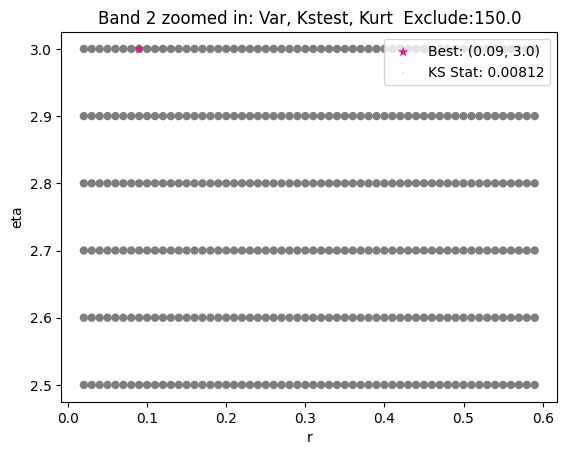

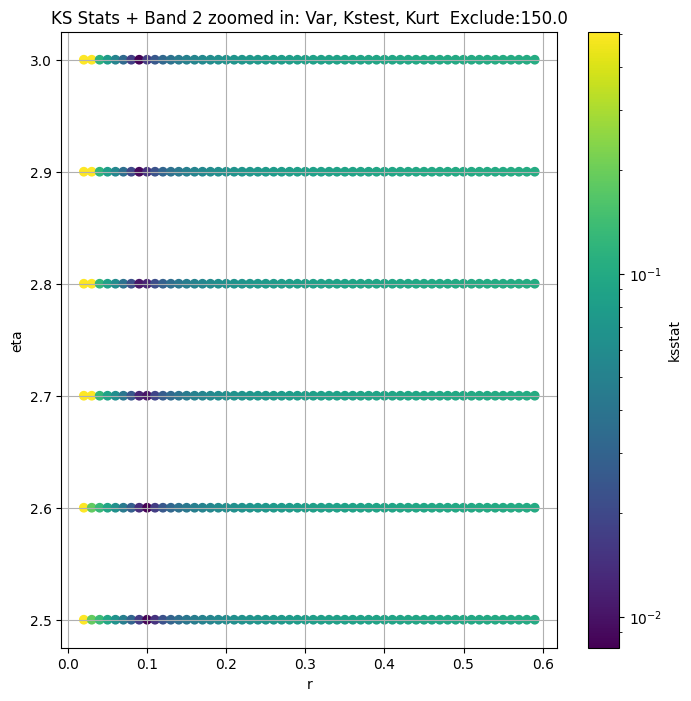

Band 5


100%|██████████| 522/522 [00:04<00:00, 119.14it/s]


Finding Minimum after computing 522 CDFs
band 5, 350.0 + 100 = 450, ksstat: 0.007106746465047498, var: 150.90765380859375


100%|██████████| 522/522 [00:04<00:00, 121.23it/s]


Finding Minimum after computing 522 CDFs
band 5, 350.0 + 75 = 425, ksstat: 0.006646060126144437, var: 154.26284790039062


100%|██████████| 522/522 [00:04<00:00, 126.60it/s]


Finding Minimum after computing 522 CDFs
band 5, 350.0 + 50 = 400, ksstat: 0.006267918798307681, var: 157.91937255859375


100%|██████████| 522/522 [00:04<00:00, 127.42it/s]


Finding Minimum after computing 522 CDFs
band 5, 350.0 + 25 = 375, ksstat: 0.005906995329913123, var: 161.8815155029297


100%|██████████| 522/522 [00:04<00:00, 129.04it/s]


Finding Minimum after computing 522 CDFs
band 5, 350.0 + 0 = 350, ksstat: 0.005591414114080151, var: 166.15975952148438


100%|██████████| 522/522 [00:04<00:00, 127.91it/s]


Finding Minimum after computing 522 CDFs
band 5, 350.0 + -25 = 325, ksstat: 0.005905019436977826, var: 170.8264923095703


100%|██████████| 522/522 [00:04<00:00, 118.97it/s]


Finding Minimum after computing 522 CDFs
band 5, 350.0 + -50 = 300, ksstat: 0.006388174504033256, var: 175.94845581054688


100%|██████████| 522/522 [00:04<00:00, 127.32it/s]


Finding Minimum after computing 522 CDFs
band 5, 350.0 + -75 = 275, ksstat: 0.007018480565456037, var: 181.82052612304688


100%|██████████| 522/522 [00:04<00:00, 124.15it/s]


Finding Minimum after computing 522 CDFs
band 5, 350.0 + -100 = 250, ksstat: 0.0077762663796071, var: 188.47613525390625
Number of samples: 100000, Without approximation : 117000.0


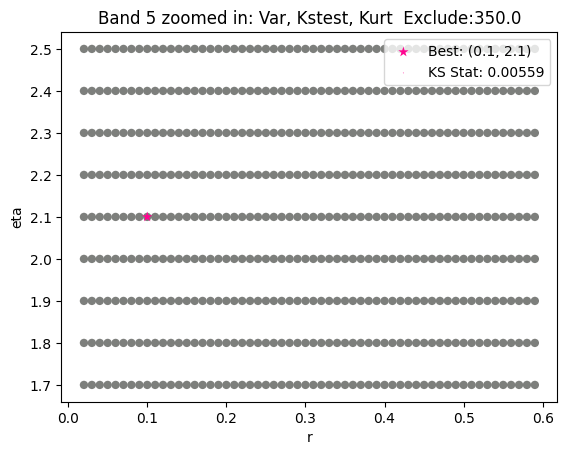

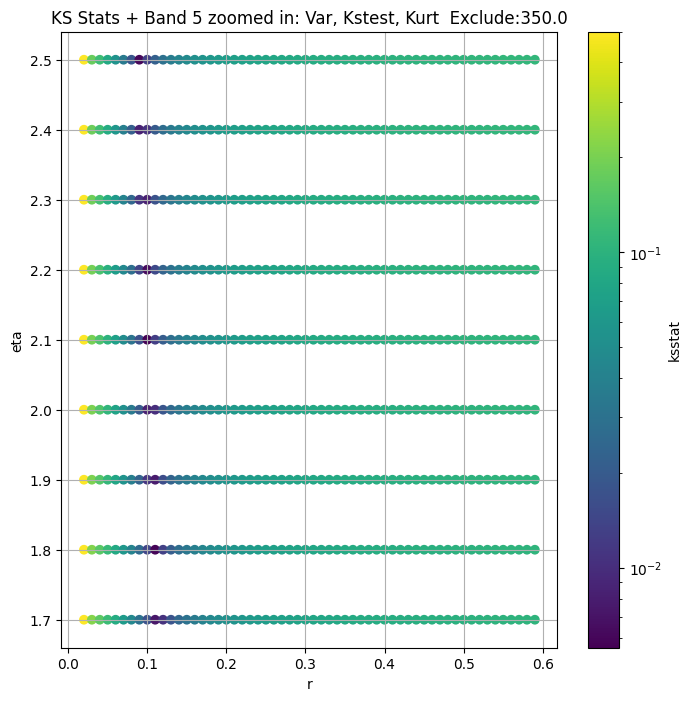

Band 8


100%|██████████| 522/522 [00:04<00:00, 127.64it/s]


Finding Minimum after computing 522 CDFs
band 8, 300.0 + 100 = 400, ksstat: 0.00631384618855424, var: 60.54183578491211


100%|██████████| 522/522 [00:04<00:00, 124.17it/s]


Finding Minimum after computing 522 CDFs
band 8, 300.0 + 75 = 375, ksstat: 0.006008290386367965, var: 61.90275955200195


100%|██████████| 522/522 [00:04<00:00, 128.37it/s]


Finding Minimum after computing 522 CDFs
band 8, 300.0 + 50 = 350, ksstat: 0.00570539495133815, var: 63.40665054321289


100%|██████████| 522/522 [00:04<00:00, 126.09it/s]


Finding Minimum after computing 522 CDFs
band 8, 300.0 + 25 = 325, ksstat: 0.005457223414373269, var: 65.06243896484375


100%|██████████| 522/522 [00:04<00:00, 124.84it/s]


Finding Minimum after computing 522 CDFs
band 8, 300.0 + 0 = 300, ksstat: 0.005144019066709138, var: 66.86557006835938


100%|██████████| 522/522 [00:04<00:00, 126.78it/s]


Finding Minimum after computing 522 CDFs
band 8, 300.0 + -25 = 275, ksstat: 0.005631417794636551, var: 68.89569854736328


100%|██████████| 522/522 [00:04<00:00, 126.45it/s]


Finding Minimum after computing 522 CDFs
band 8, 300.0 + -50 = 250, ksstat: 0.0064459218530594775, var: 71.21391296386719


100%|██████████| 522/522 [00:04<00:00, 124.18it/s]


Finding Minimum after computing 522 CDFs
band 8, 300.0 + -75 = 225, ksstat: 0.0068691431151255145, var: 73.86077117919922


100%|██████████| 522/522 [00:04<00:00, 127.29it/s]


Finding Minimum after computing 522 CDFs
band 8, 300.0 + -100 = 200, ksstat: 0.00833228800192852, var: 76.89482116699219
Number of samples: 100000, Without approximation : 189000.0


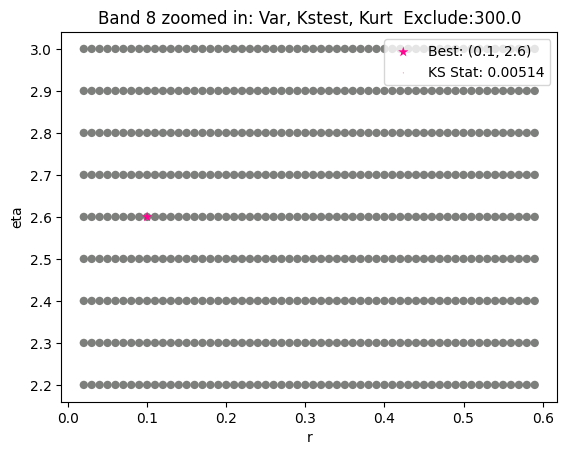

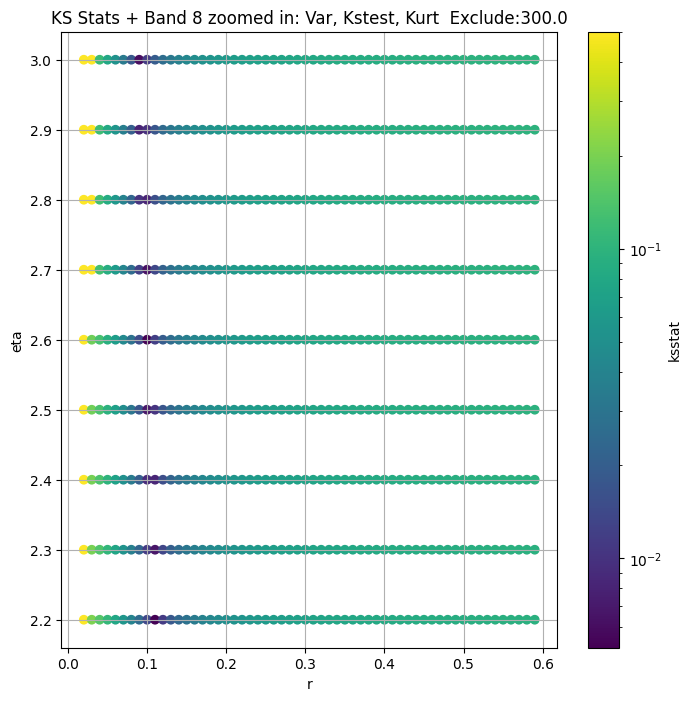

Band 11


100%|██████████| 522/522 [00:04<00:00, 124.40it/s]


Finding Minimum after computing 522 CDFs
band 11, 200.0 + 100 = 300, ksstat: 0.004539597946287222, var: 30.484628677368164


100%|██████████| 522/522 [00:04<00:00, 128.14it/s]


Finding Minimum after computing 522 CDFs
band 11, 200.0 + 75 = 275, ksstat: 0.004227297765751148, var: 31.280475616455078


100%|██████████| 522/522 [00:04<00:00, 128.13it/s]


Finding Minimum after computing 522 CDFs
band 11, 200.0 + 50 = 250, ksstat: 0.0038790264252416273, var: 32.17323684692383


100%|██████████| 522/522 [00:04<00:00, 130.32it/s]


Finding Minimum after computing 522 CDFs
band 11, 200.0 + 25 = 225, ksstat: 0.0035098002335690603, var: 33.17947769165039


100%|██████████| 522/522 [00:04<00:00, 130.00it/s]


Finding Minimum after computing 522 CDFs
band 11, 200.0 + 0 = 200, ksstat: 0.003739003164514032, var: 34.3436279296875


100%|██████████| 522/522 [00:04<00:00, 129.52it/s]


Finding Minimum after computing 522 CDFs
band 11, 200.0 + -25 = 175, ksstat: 0.0044276769309189445, var: 35.731353759765625


100%|██████████| 522/522 [00:03<00:00, 131.95it/s]


Finding Minimum after computing 522 CDFs
band 11, 200.0 + -50 = 150, ksstat: 0.005536703689799971, var: 37.413726806640625


100%|██████████| 522/522 [00:03<00:00, 132.40it/s]


Finding Minimum after computing 522 CDFs
band 11, 200.0 + -75 = 125, ksstat: 0.006962257906985014, var: 39.50522232055664


100%|██████████| 522/522 [00:03<00:00, 130.67it/s]


Finding Minimum after computing 522 CDFs
band 11, 200.0 + -100 = 100, ksstat: 0.00833700344083399, var: 42.169315338134766
Number of samples: 100000, Without approximation : 495000.0


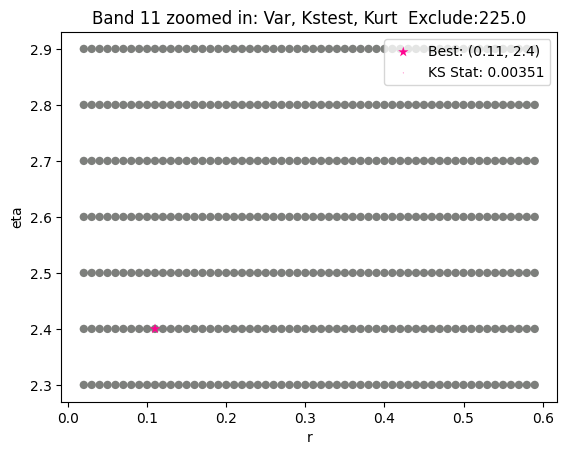

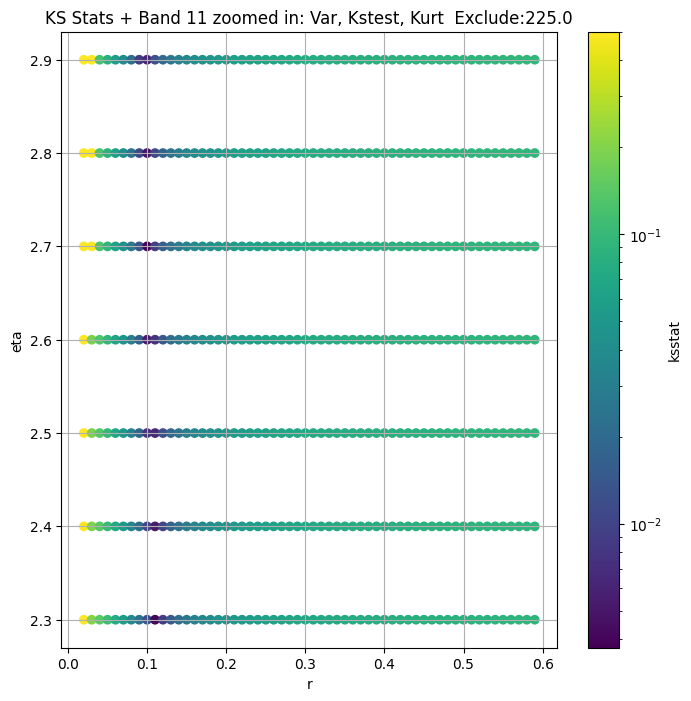

Band 14


100%|██████████| 522/522 [00:04<00:00, 129.69it/s]


Finding Minimum after computing 522 CDFs
band 14, 200.0 + 100 = 300, ksstat: 0.004154322051578792, var: 13.367859840393066


100%|██████████| 522/522 [00:03<00:00, 130.99it/s]


Finding Minimum after computing 522 CDFs
band 14, 200.0 + 75 = 275, ksstat: 0.0037168440518255963, var: 13.671663284301758


100%|██████████| 522/522 [00:03<00:00, 131.35it/s]


Finding Minimum after computing 522 CDFs
band 14, 200.0 + 50 = 250, ksstat: 0.003248034344247877, var: 14.014368057250977


100%|██████████| 522/522 [00:03<00:00, 131.67it/s]


Finding Minimum after computing 522 CDFs
band 14, 200.0 + 25 = 225, ksstat: 0.0029218535743200658, var: 14.405406951904297


100%|██████████| 522/522 [00:03<00:00, 130.55it/s]


Finding Minimum after computing 522 CDFs
band 14, 200.0 + 0 = 200, ksstat: 0.0026551511115235904, var: 14.858236312866211


100%|██████████| 522/522 [00:03<00:00, 142.49it/s]


Finding Minimum after computing 522 CDFs
band 14, 200.0 + -25 = 175, ksstat: 0.0024240512510600443, var: 15.396127700805664


100%|██████████| 522/522 [00:03<00:00, 134.21it/s]


Finding Minimum after computing 522 CDFs
band 14, 200.0 + -50 = 150, ksstat: 0.002583367605535347, var: 16.050779342651367


100%|██████████| 522/522 [00:04<00:00, 129.23it/s]


Finding Minimum after computing 522 CDFs
band 14, 200.0 + -75 = 125, ksstat: 0.0035036675772710524, var: 16.871559143066406


100%|██████████| 522/522 [00:04<00:00, 123.86it/s]


Finding Minimum after computing 522 CDFs
band 14, 200.0 + -100 = 100, ksstat: 0.00477030797710809, var: 17.914573669433594
Number of samples: 100000, Without approximation : 1134000.0


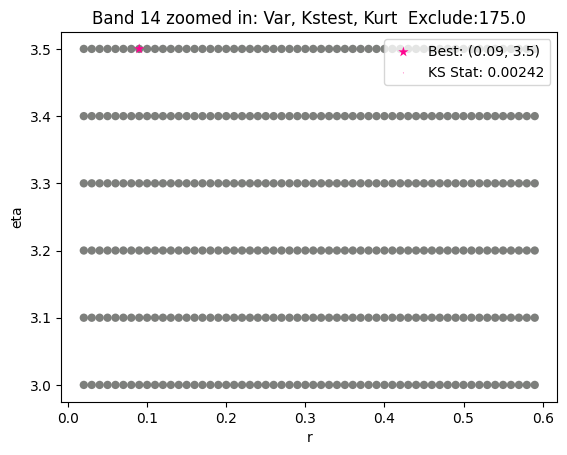

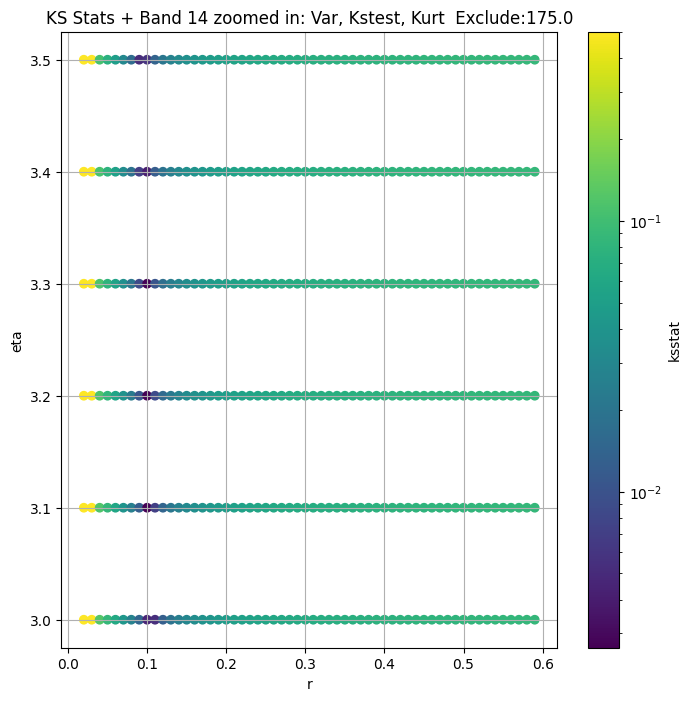

Band 17


100%|██████████| 522/522 [00:04<00:00, 121.46it/s]


Finding Minimum after computing 522 CDFs
band 17, 150.0 + 100 = 250, ksstat: 0.003958963967774995, var: 7.030638217926025


100%|██████████| 522/522 [00:04<00:00, 125.73it/s]


Finding Minimum after computing 522 CDFs
band 17, 150.0 + 75 = 225, ksstat: 0.0033287182750682334, var: 7.205704212188721


100%|██████████| 522/522 [00:04<00:00, 125.15it/s]


Finding Minimum after computing 522 CDFs
band 17, 150.0 + 50 = 200, ksstat: 0.0027414031518233524, var: 7.406673431396484


100%|██████████| 522/522 [00:04<00:00, 126.38it/s]


Finding Minimum after computing 522 CDFs
band 17, 150.0 + 25 = 175, ksstat: 0.0023113448293661035, var: 7.641427516937256


100%|██████████| 522/522 [00:04<00:00, 126.25it/s]


Finding Minimum after computing 522 CDFs
band 17, 150.0 + 0 = 150, ksstat: 0.0020408949448707694, var: 7.923802852630615


100%|██████████| 522/522 [00:04<00:00, 126.58it/s]


Finding Minimum after computing 522 CDFs
band 17, 150.0 + -25 = 125, ksstat: 0.0023272478540593694, var: 8.275053024291992


100%|██████████| 522/522 [00:04<00:00, 125.87it/s]


Finding Minimum after computing 522 CDFs
band 17, 150.0 + -50 = 100, ksstat: 0.003514216945535331, var: 8.729887008666992


100%|██████████| 522/522 [00:04<00:00, 120.56it/s]


Finding Minimum after computing 522 CDFs
band 17, 150.0 + -75 = 75, ksstat: 0.00457716790982704, var: 9.3532133102417


100%|██████████| 522/522 [00:04<00:00, 121.77it/s]


Finding Minimum after computing 522 CDFs
band 17, 150.0 + -100 = 50, ksstat: 0.007167694428874327, var: 10.28152847290039
Number of samples: 100000, Without approximation : 2574000.0


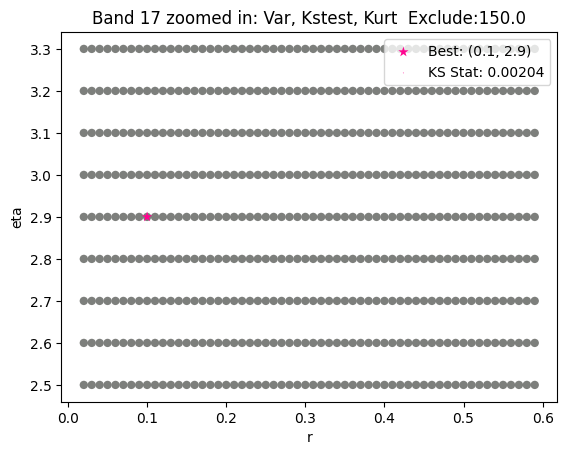

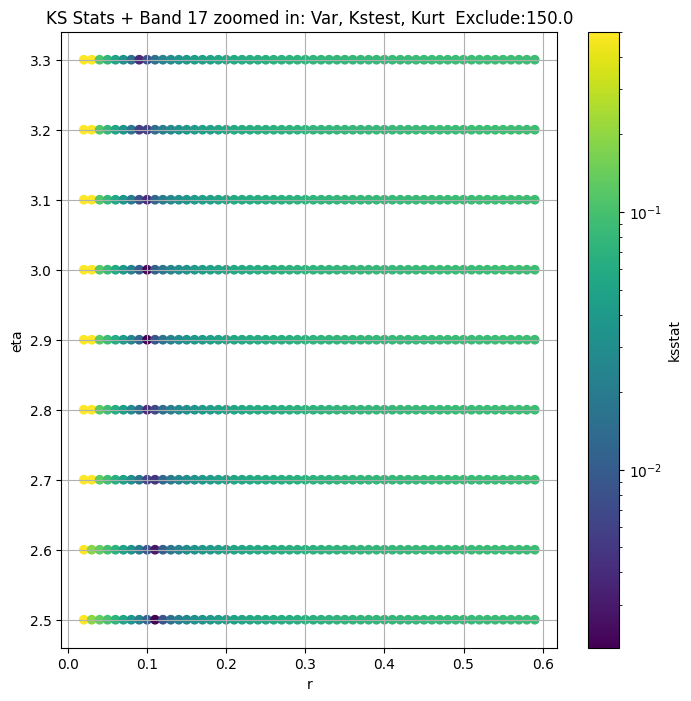

Band 20


100%|██████████| 522/522 [00:04<00:00, 123.20it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + 100 = 300, ksstat: 0.005560556881429972, var: 3.797637701034546


100%|██████████| 522/522 [00:04<00:00, 126.78it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + 75 = 275, ksstat: 0.005032600727762071, var: 3.8812952041625977


100%|██████████| 522/522 [00:04<00:00, 124.49it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + 50 = 250, ksstat: 0.004513108709215927, var: 3.9746079444885254


100%|██████████| 522/522 [00:04<00:00, 122.96it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + 25 = 225, ksstat: 0.003958134653205884, var: 4.080140590667725


100%|██████████| 522/522 [00:04<00:00, 121.53it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + 0 = 200, ksstat: 0.0033613042945208026, var: 4.201747894287109


100%|██████████| 522/522 [00:04<00:00, 125.67it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + -25 = 175, ksstat: 0.003379806404401997, var: 4.344603061676025


100%|██████████| 522/522 [00:04<00:00, 127.87it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + -50 = 150, ksstat: 0.004270750601091611, var: 4.515660762786865


100%|██████████| 522/522 [00:04<00:00, 123.19it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + -75 = 125, ksstat: 0.00515304210584544, var: 4.728733539581299


100%|██████████| 522/522 [00:04<00:00, 127.26it/s]


Finding Minimum after computing 522 CDFs
band 20, 200.0 + -100 = 100, ksstat: 0.005430887253953742, var: 5.0038909912109375
Number of samples: 100000, Without approximation : 5967000.0


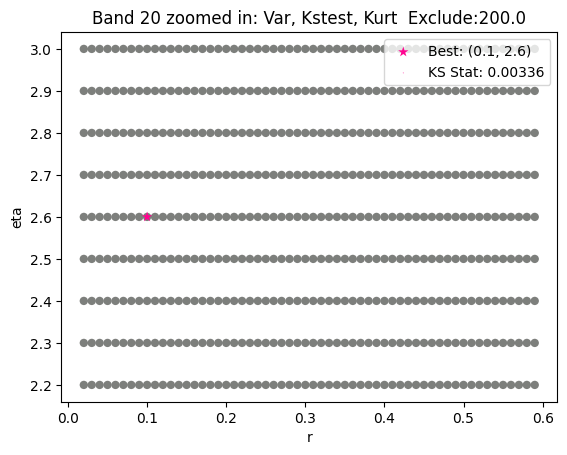

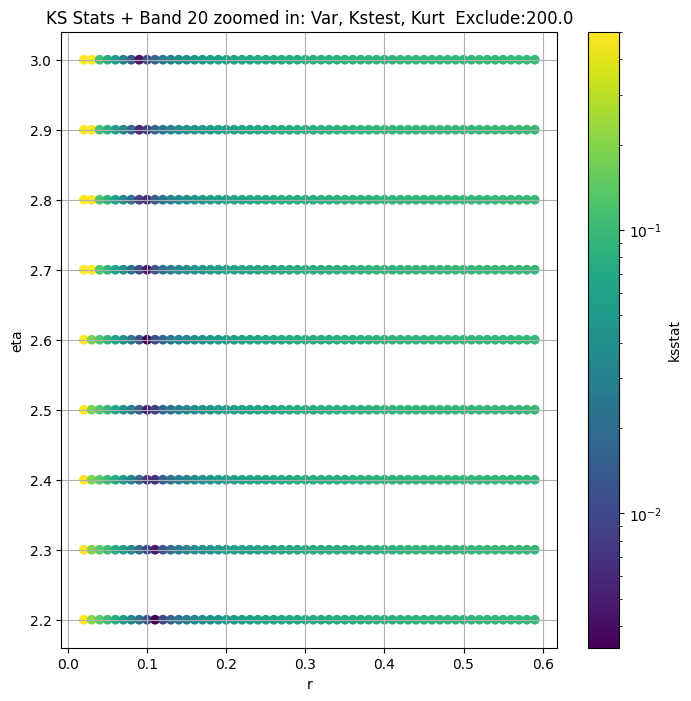

Band 23


100%|██████████| 522/522 [00:04<00:00, 120.38it/s]


Finding Minimum after computing 522 CDFs
band 23, 200.0 + 100 = 300, ksstat: 0.006218568575458383, var: 1.44849693775177


100%|██████████| 522/522 [00:04<00:00, 126.47it/s]


Finding Minimum after computing 522 CDFs
band 23, 200.0 + 75 = 275, ksstat: 0.005764788441377636, var: 1.4796476364135742


100%|██████████| 522/522 [00:04<00:00, 129.56it/s]


Finding Minimum after computing 522 CDFs
band 23, 200.0 + 50 = 250, ksstat: 0.005376132848746929, var: 1.5139107704162598


100%|██████████| 522/522 [00:04<00:00, 123.70it/s]


Finding Minimum after computing 522 CDFs
band 23, 200.0 + 25 = 225, ksstat: 0.004866777271573912, var: 1.5520944595336914


100%|██████████| 522/522 [00:04<00:00, 127.47it/s]


Finding Minimum after computing 522 CDFs
band 23, 200.0 + 0 = 200, ksstat: 0.004359138986482658, var: 1.595347285270691


100%|██████████| 522/522 [00:04<00:00, 125.83it/s]


Finding Minimum after computing 522 CDFs
band 23, 200.0 + -25 = 175, ksstat: 0.004639698423184124, var: 1.6454288959503174


100%|██████████| 522/522 [00:04<00:00, 124.43it/s]


Finding Minimum after computing 522 CDFs
band 23, 200.0 + -50 = 150, ksstat: 0.005105913848510335, var: 1.7051018476486206


100%|██████████| 522/522 [00:04<00:00, 120.41it/s]


Finding Minimum after computing 522 CDFs
band 23, 200.0 + -75 = 125, ksstat: 0.005819707797840579, var: 1.7785999774932861


100%|██████████| 522/522 [00:04<00:00, 130.00it/s]


Finding Minimum after computing 522 CDFs
band 23, 200.0 + -100 = 100, ksstat: 0.00677589615741897, var: 1.8733831644058228
Number of samples: 100000, Without approximation : 13887000.0


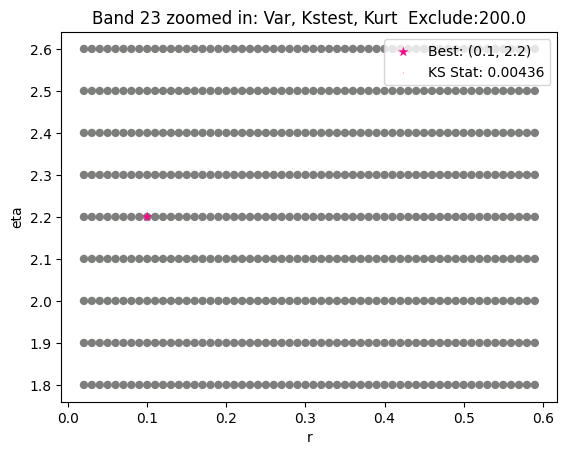

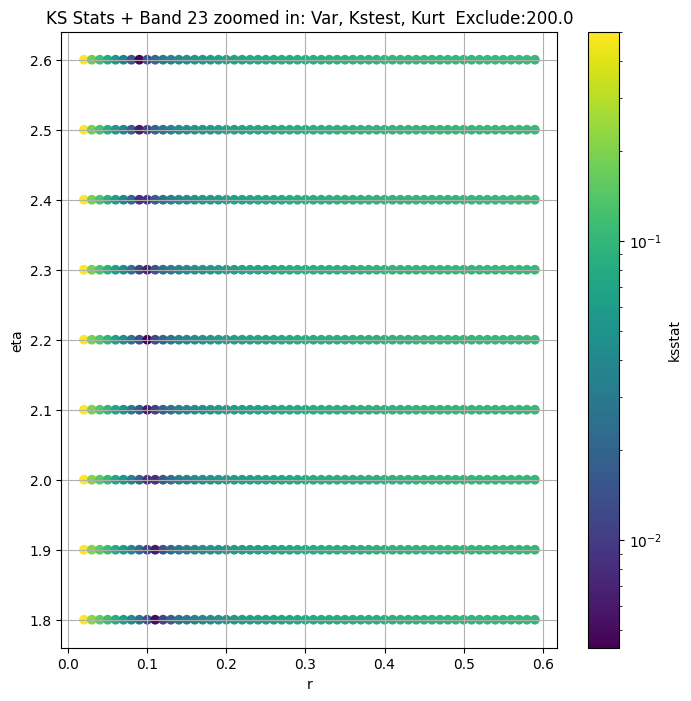

Band 26


100%|██████████| 522/522 [00:04<00:00, 124.40it/s]


Finding Minimum after computing 522 CDFs
band 26, 250.0 + 100 = 350, ksstat: 0.007789339457730526, var: 0.34743282198905945


100%|██████████| 522/522 [00:04<00:00, 127.75it/s]


Finding Minimum after computing 522 CDFs
band 26, 250.0 + 75 = 325, ksstat: 0.0073078117695587475, var: 0.35498619079589844


100%|██████████| 522/522 [00:04<00:00, 122.94it/s]


Finding Minimum after computing 522 CDFs
band 26, 250.0 + 50 = 300, ksstat: 0.006981918051241598, var: 0.363162636756897


100%|██████████| 522/522 [00:04<00:00, 121.58it/s]


Finding Minimum after computing 522 CDFs
band 26, 250.0 + 25 = 275, ksstat: 0.006586809271948546, var: 0.37207186222076416


100%|██████████| 522/522 [00:04<00:00, 123.74it/s]


Finding Minimum after computing 522 CDFs
band 26, 250.0 + 0 = 250, ksstat: 0.006114605668789186, var: 0.3818890452384949


100%|██████████| 522/522 [00:04<00:00, 127.77it/s]


Finding Minimum after computing 522 CDFs
band 26, 250.0 + -25 = 225, ksstat: 0.005546004843428043, var: 0.39284712076187134


100%|██████████| 522/522 [00:04<00:00, 121.43it/s]


Finding Minimum after computing 522 CDFs
band 26, 250.0 + -50 = 200, ksstat: 0.005579281406654313, var: 0.4052848219871521


100%|██████████| 522/522 [00:04<00:00, 123.63it/s]


Finding Minimum after computing 522 CDFs
band 26, 250.0 + -75 = 175, ksstat: 0.006063738278332287, var: 0.41967228055000305


100%|██████████| 522/522 [00:04<00:00, 126.11it/s]


Finding Minimum after computing 522 CDFs
band 26, 250.0 + -100 = 150, ksstat: 0.006839583070480382, var: 0.4367579221725464
Number of samples: 100000, Without approximation : 31968000.0


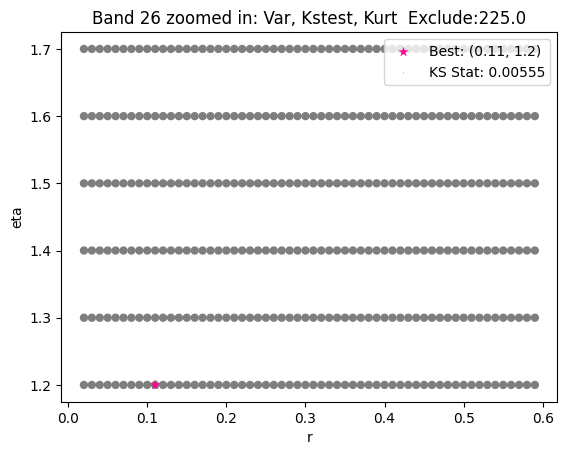

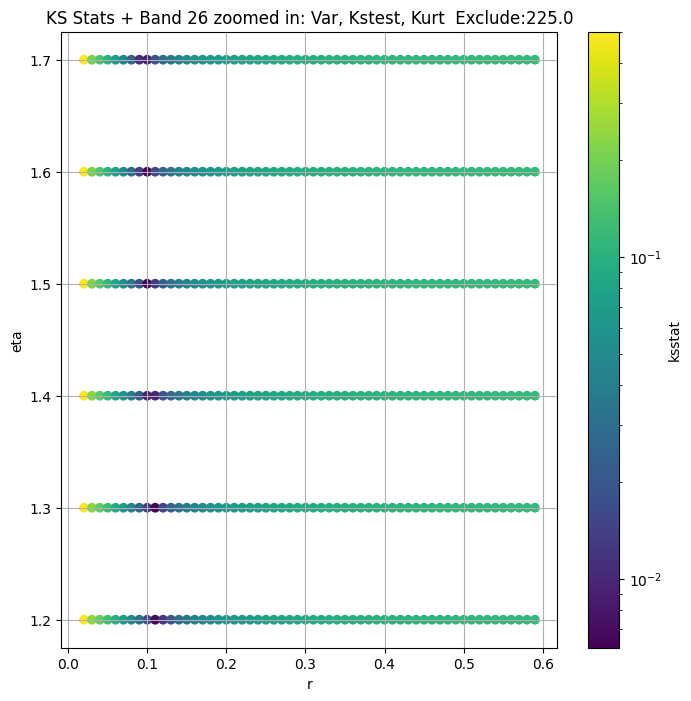

Band 29


100%|██████████| 522/522 [00:04<00:00, 119.85it/s]


Finding Minimum after computing 522 CDFs
band 29, 300.0 + 100 = 400, ksstat: 0.010397619514648793, var: 0.03943793475627899


100%|██████████| 522/522 [00:04<00:00, 123.79it/s]


Finding Minimum after computing 522 CDFs
band 29, 300.0 + 75 = 375, ksstat: 0.009865045739277933, var: 0.04027949273586273


100%|██████████| 522/522 [00:04<00:00, 125.63it/s]


Finding Minimum after computing 522 CDFs
band 29, 300.0 + 50 = 350, ksstat: 0.00994934552040927, var: 0.04117891192436218


100%|██████████| 522/522 [00:04<00:00, 123.71it/s]


Finding Minimum after computing 522 CDFs
band 29, 300.0 + 25 = 325, ksstat: 0.009354249852366436, var: 0.04214564710855484


100%|██████████| 522/522 [00:04<00:00, 124.45it/s]


Finding Minimum after computing 522 CDFs
band 29, 300.0 + 0 = 300, ksstat: 0.009283440973045204, var: 0.04319237545132637


100%|██████████| 522/522 [00:04<00:00, 127.19it/s]


Finding Minimum after computing 522 CDFs
band 29, 300.0 + -25 = 275, ksstat: 0.008691444681392158, var: 0.04433320835232735


100%|██████████| 522/522 [00:04<00:00, 125.92it/s]


Finding Minimum after computing 522 CDFs
band 29, 300.0 + -50 = 250, ksstat: 0.010262356485532503, var: 0.0455879308283329


100%|██████████| 522/522 [00:04<00:00, 126.44it/s]


Finding Minimum after computing 522 CDFs
band 29, 300.0 + -75 = 225, ksstat: 0.00961869291155637, var: 0.04698551073670387


100%|██████████| 522/522 [00:04<00:00, 129.42it/s]


Finding Minimum after computing 522 CDFs
band 29, 300.0 + -100 = 200, ksstat: 0.010897406280571925, var: 0.048567455261945724
Number of samples: 100000, Without approximation : 73701000.0


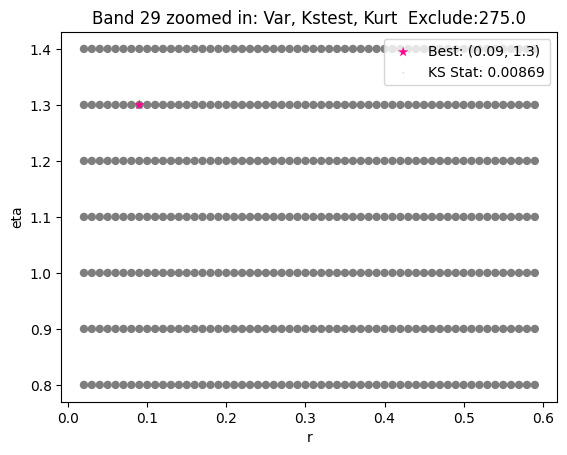

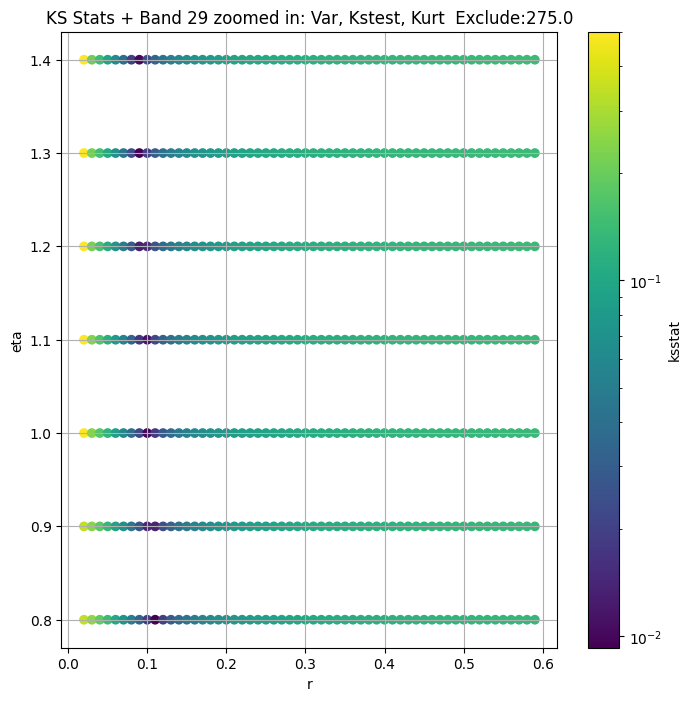

Band 32


100%|██████████| 522/522 [00:04<00:00, 129.77it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + 100 = 600, ksstat: 0.011715925695765034, var: 0.0036282374057918787


100%|██████████| 522/522 [00:04<00:00, 129.32it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + 75 = 575, ksstat: 0.01136245273065999, var: 0.0036870259791612625


100%|██████████| 522/522 [00:04<00:00, 127.96it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + 50 = 550, ksstat: 0.011089091679157316, var: 0.0037482569459825754


100%|██████████| 522/522 [00:04<00:00, 127.14it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + 25 = 525, ksstat: 0.010776564498769542, var: 0.003812166629359126


100%|██████████| 522/522 [00:04<00:00, 127.43it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + 0 = 500, ksstat: 0.010706502392833828, var: 0.003879010444507003


100%|██████████| 522/522 [00:03<00:00, 133.00it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + -25 = 475, ksstat: 0.010261545484477573, var: 0.003949082922190428


100%|██████████| 522/522 [00:04<00:00, 128.08it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + -50 = 450, ksstat: 0.011276274320329821, var: 0.0040227510035037994


100%|██████████| 522/522 [00:03<00:00, 131.08it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + -75 = 425, ksstat: 0.010591027328455072, var: 0.004100391641259193


100%|██████████| 522/522 [00:04<00:00, 128.47it/s]


Finding Minimum after computing 522 CDFs
band 32, 500.0 + -100 = 400, ksstat: 0.011829360932547967, var: 0.004182485863566399
Number of samples: 100000, Without approximation : 59634000.0


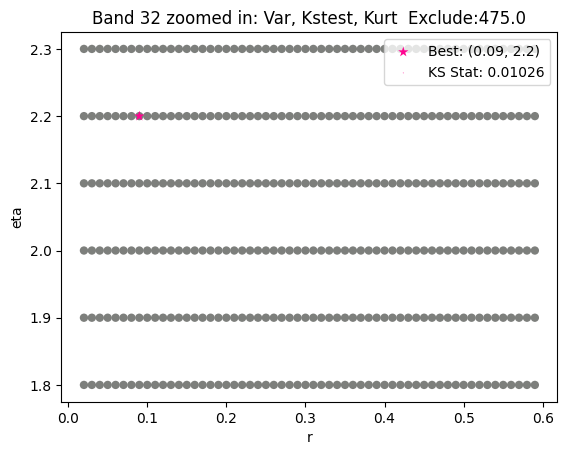

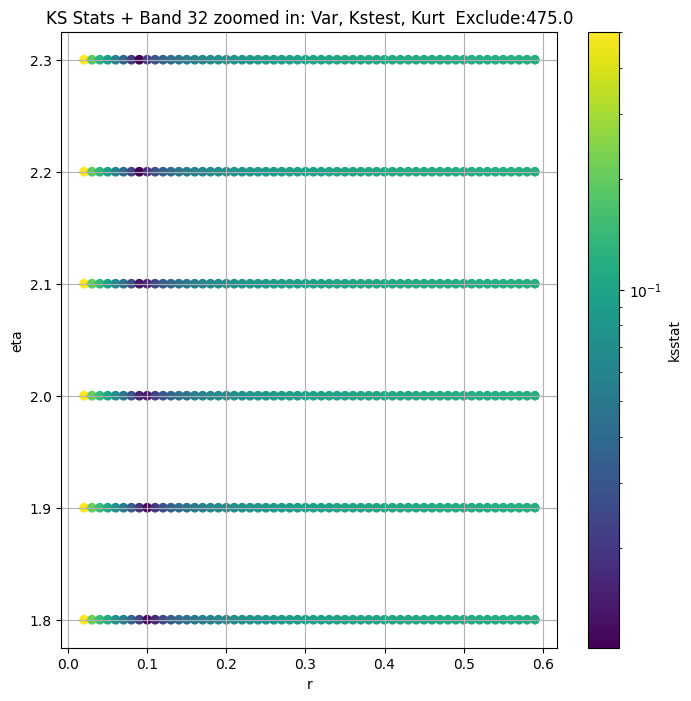

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
band,,,,,,,,,,,,,,,,,,,,
2,1142.248300,671.469300,1944.989000,473.18463,99.004295,1019.8701,45000.0,0.008210,0.1,2.6,8.526864e-15,150.0,317.847748,0.006398,0.008117,0.09,3.0,1.472758e-17,150.0,28476
5,758.162230,365.148160,2692.950400,2945.43360,101.462210,5367.8350,117000.0,0.005591,0.1,2.1,1.435313e-14,350.0,166.159760,0.003969,0.005591,0.10,2.1,1.435313e-14,350.0,58500
8,241.405010,134.156190,529.040800,918.95044,93.302230,2766.5867,189000.0,0.005144,0.1,2.6,1.793795e-15,300.0,66.865570,0.003123,0.005144,0.10,2.6,1.793795e-15,300.0,70875
11,139.544980,56.528194,599.460300,6517.12160,80.002920,6412.9240,495000.0,0.003739,0.1,2.7,7.406790e-16,200.0,33.179478,0.001930,0.003510,0.11,2.4,1.035123e-13,225.0,156619
14,45.202160,23.660954,126.899790,1856.47970,73.761430,4089.5234,1134000.0,0.002655,0.1,3.1,1.399905e-16,200.0,15.396128,0.001275,0.002424,0.09,3.5,2.443398e-19,175.0,318937
17,29.421543,11.309689,173.463560,9698.96400,65.262900,7472.8240,2574000.0,0.002041,0.1,2.9,1.119840e-16,150.0,7.923803,0.000846,0.002041,0.10,2.9,1.119840e-16,150.0,458115
20,16.877602,6.535955,89.357990,8663.62000,69.641340,7133.9710,5967000.0,0.003361,0.1,2.6,1.127198e-16,200.0,4.201748,0.000556,0.003361,0.10,2.6,1.127198e-16,200.0,157332
23,7.124417,2.409751,47.371037,16824.38000,62.361816,8305.8750,13887000.0,0.004359,0.1,2.2,1.078501e-16,200.0,1.595347,0.000364,0.004359,0.10,2.2,1.078501e-16,200.0,97749
26,3.963180,0.637729,39.924670,32372.20000,72.455315,9320.1260,31968000.0,0.006115,0.1,1.6,1.241516e-16,250.0,0.392847,0.000240,0.005546,0.11,1.2,2.356897e-14,225.0,62437


In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

EngineError: Unknown exception

## Comparing with Gaussian and Laplace Priors

In [ ]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [ ]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

## Results

In [ ]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/CSVs/master_df.csv'

In [ ]:
master_df.filter(regex="kstest_stat.*")

In [ ]:
master_df.filter(regex="best.*")

In [ ]:
eng.quit()